FixMatch: https://arxiv.org/ftp/arxiv/papers/2001/2001.07685.pdf
AutoAugment:https://towardsdatascience.com/how-to-improve-your-image-classifier-with-googles-autoaugment-77643f0be0c9 
https://arxiv.org/pdf/1805.09501.pdf

In [ ]:
# code in this file is adpated from
# https://github.com/ildoonet/pytorch-randaugment/blob/master/RandAugment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/third_party/auto_augment/augmentations.py
# https://github.com/google-research/fixmatch/blob/master/libml/ctaugment.py

import random

import numpy as np
import PIL
import PIL.ImageOps
import PIL.ImageEnhance
import PIL.ImageDraw
from PIL import Image

PARAMETER_MAX = 10


def AutoContrast(img, **kwarg):
    return PIL.ImageOps.autocontrast(img)


def Brightness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Brightness(img).enhance(v)


def Color(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Color(img).enhance(v)


def Contrast(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Contrast(img).enhance(v)


def Cutout(img, v, max_v, bias=0):
    if v == 0:
        return img
    v = _float_parameter(v, max_v) + bias
    v = int(v * min(img.size))
    return CutoutAbs(img, v)


def CutoutAbs(img, v, **kwarg):
    w, h = img.size
    x0 = np.random.uniform(0, w)
    y0 = np.random.uniform(0, h)
    x0 = int(max(0, x0 - v / 2.))
    y0 = int(max(0, y0 - v / 2.))
    x1 = int(min(w, x0 + v))
    y1 = int(min(h, y0 + v))
    xy = (x0, y0, x1, y1)
    # gray
    color = (127, 127, 127)
    img = img.copy()
    PIL.ImageDraw.Draw(img).rectangle(xy, color)
    return img


def Equalize(img, **kwarg):
    return PIL.ImageOps.equalize(img)


def Identity(img, **kwarg):
    return img


def Invert(img, **kwarg):
    return PIL.ImageOps.invert(img)


def Posterize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.posterize(img, v)


def Rotate(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.rotate(v)


def Sharpness(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    return PIL.ImageEnhance.Sharpness(img).enhance(v)


def ShearX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, v, 0, 0, 1, 0))


def ShearY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, v, 1, 0))


def Solarize(img, v, max_v, bias=0):
    v = _int_parameter(v, max_v) + bias
    return PIL.ImageOps.solarize(img, 256 - v)


def SolarizeAdd(img, v, max_v, bias=0, threshold=128):
    v = _int_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    img_np = np.array(img).astype(np.int)
    img_np = img_np + v
    img_np = np.clip(img_np, 0, 255)
    img_np = img_np.astype(np.uint8)
    img = Image.fromarray(img_np)
    return PIL.ImageOps.solarize(img, threshold)


def TranslateX(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[0])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, v, 0, 1, 0))


def TranslateY(img, v, max_v, bias=0):
    v = _float_parameter(v, max_v) + bias
    if random.random() < 0.5:
        v = -v
    v = int(v * img.size[1])
    return img.transform(img.size, PIL.Image.AFFINE, (1, 0, 0, 0, 1, v))


def _float_parameter(v, max_v):
    return float(v) * max_v / PARAMETER_MAX


def _int_parameter(v, max_v):
    return int(v * max_v / PARAMETER_MAX)


def fixmatch_augment_pool():
    # FixMatch paper
    augs = [(AutoContrast, None, None),
            (Brightness, 0.9, 0.05),
            (Color, 0.9, 0.05),
            (Contrast, 0.9, 0.05),
            (Equalize, None, None),
            (Identity, None, None),
            (Posterize, 4, 4),
            (Rotate, 30, 0),
            (Sharpness, 0.9, 0.05),
            (ShearX, 0.3, 0),
            (ShearY, 0.3, 0),
            (Solarize, 256, 0),
            (TranslateX, 0.3, 0),
            (TranslateY, 0.3, 0)]
    return augs


class RandAugmentMC(object):
    def __init__(self, n, m):
        assert n >= 1
        assert 1 <= m <= 10
        self.n = n
        self.m = m
        self.augment_pool = fixmatch_augment_pool()

    def __call__(self, img):
        ops = random.choices(self.augment_pool, k=self.n)
        for op, max_v, bias in ops:
            v = np.random.randint(1, self.m)
            if random.random() < 0.5:
                img = op(img, v=v, max_v=max_v, bias=bias)
        img = CutoutAbs(img, int(32*0.5))
        return img

### Dataset

In [ ]:
import numpy as np
import math
import torch
from PIL import Image
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
classes = 10
train_total = 50000

#modified from: 
#https://github.com/kekmodel/FixMatch-pytorch/blob/master/dataset/cifar.py 
def x_u_split(labels, labeled_per_class):
    np.random.seed(0) #make sure split are the same
    labels = np.array(labels)
    labeled_idx = []
    for i in range(classes):
        idx = np.where(labels == i)[0]
        idx = np.random.choice(idx, labeled_per_class, False)
        labeled_idx.extend(idx)
    labeled_idx = np.array(labeled_idx)
    np.random.shuffle(labeled_idx)
    np.random.seed() #optionally restore rng
    return labeled_idx, np.setdiff1d(range(train_total), labeled_idx)

class CIFAR10SSL(datasets.CIFAR10):
    def __init__(self, root, indexs, train=True,
                 transform=None, target_transform=None,
                 download=False):
        super().__init__(root, train=train,
                         transform=transform,
                         target_transform=target_transform,
                         download=download)
        if indexs is not None:
            self.data = self.data[indexs]
            self.targets = np.array(self.targets)[indexs]

    def __getitem__(self, index):
        img, target = self.data[index], self.targets[index]
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target



Augmentations

In [ ]:
mean = [0.49139968, 0.48215827, 0.44653124]
std = [0.24703233, 0.24348505, 0.26158768]

transform_labeled = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

class transform_unlabeled(object):
    def __init__(self):
      self.weak = transforms.Compose([
          transforms.RandomHorizontalFlip()])

      self.strong = transforms.Compose([
          transforms.RandomHorizontalFlip(),
          RandAugmentMC(n=2, m=10)])
      
      self.tensor = transforms.Compose([
          transforms.ToTensor(),
          transforms.Normalize(mean=mean, std=std)])

    def __call__(self, x):
        weak = self.weak(x)
        strong = self.strong(x)
        return self.tensor(weak), self.tensor(strong)


transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean,std)])

### Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import math
import gc

## Train

In [ ]:
def train_model(model,
    l_train_dataloader,
    u_train_dataloader,
    test_dataloader,
    lr,
    total_epochs,
    criterion,
    optimizer,
    scheduler,
    save_min_acc,
    save_path,
    eval_steps = 1024,
    print_every = 5):
  labeled_iter = iter(l_train_dataloader)
  unlabeled_iter = iter(u_train_dataloader)
  train_loss = []
  best_acc = 0
  for epoch in range(total_epochs):
    time1 = time.time()
    
    #train
    model.train()

    total_loss = 0
    for step in range(eval_steps):
      try:
        labeled_data, labeled_target = next(labeled_iter)
      except:
        labeled_iter = iter(l_train_dataloader)
        labeled_data, labeled_target = next(labeled_iter)
      try:
        (u_data_w, u_data_s), _ = next(unlabeled_iter)
      except:
        unlabeled_iter = iter(u_train_dataloader)
        (u_data_w, u_data_s), _ = next(unlabeled_iter)

      if gpu_boole:
        labeled_data, labeled_target = labeled_data.cuda(), labeled_target.cuda()
        u_data_w, u_data_s = u_data_w.cuda(), u_data_s.cuda()
      
      
      #labeled loss
      l_output = model(labeled_data)
      labeled_loss = criterion(l_output, labeled_target)

      #unlabeded loss
      
      #u_data_w = weak_img_augmentation(unlabeled_data)
      u_w_output = torch.softmax(model(u_data_w).detach(), dim=-1)
      probs, pseudo_labels = torch.max(u_w_output, 1)
      mask = probs.ge(threshold).float()
      #u_data_s = strong_img_augmentation(unlabeled_data)
      u_s_output = model(u_data_s)
      unlabeded_loss = (unlabeded_criterion(u_s_output, pseudo_labels)*mask).mean()

      loss = labeled_loss+weight*unlabeded_loss
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

      if scheduler is not None:
        scheduler.step()

    train_loss.append(total_loss/eval_steps)
    time2 = time.time()
    
    if (epoch+1) % print_every == 0:
      #val
      model.eval()
      correct_sum = 0
      with torch.no_grad():
        for data, target in test_dataloader:
          if gpu_boole:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          _, predicted = torch.max(output.data, 1)
          correct_sum += (predicted.float() == target.float()).sum().item()
      val_acc = correct_sum/len(test_dataset)

      
      print('epoch:', epoch+1, ' train loss:', total_loss/eval_steps, \
            'val accuracy:', val_acc)
      print('ETA of completion:',(time2 - time1)*(total_epochs - epoch - 1)/60,'minutes')
      if val_acc > save_min_acc and best_acc < val_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), save_path)

  arr = np.array(train_loss)
  file = open("/content/drive/MyDrive/MLDL/cifar/model/10_50_losses.txt", "a")
  content = str(arr)
  file.write(content)
  file.close()

  plt.plot(train_loss, label = 'training loss')
  plt.xlabel('Epoch Number')
  plt.ylabel('Average Traning Loss At Each Epoch')
  plt.legend()
  plt.title('Training Loss vs Epochs')
  plt.show()

### 50

In [ ]:
root = './tmp'
#adjust this for labeled and unlabeled split
labeled_per_class = 50

base_dataset = datasets.CIFAR10(
    root, train=True, download=True)

train_labeled_idxs, train_unlabeled_idxs = x_u_split(base_dataset.targets, labeled_per_class)

train_labeled_dataset = CIFAR10SSL(
    root, train_labeled_idxs, train=True,
    transform=transform_labeled)
 
train_unlabeled_dataset = CIFAR10SSL(
    root, train_unlabeled_idxs, train=True,
    transform=transform_unlabeled())

test_dataset = datasets.CIFAR10(
    root, train=False, transform=transform_test, download=False)

Files already downloaded and verified


In [ ]:
print(len(train_labeled_dataset), len(train_unlabeled_dataset))

500 49500


epoch: 5  train loss: 0.18285557319177315 val accuracy: 0.754
ETA of completion: 594.8350985248884 minutes
epoch: 10  train loss: 0.18129274586681277 val accuracy: 0.7588
ETA of completion: 558.6675785779953 minutes
epoch: 15  train loss: 0.18264213235670468 val accuracy: 0.7886
ETA of completion: 530.2820774316788 minutes
epoch: 20  train loss: 0.16770872326742392 val accuracy: 0.7945
ETA of completion: 499.72954750061035 minutes
epoch: 25  train loss: 0.17649704615905648 val accuracy: 0.7949
ETA of completion: 474.3307450413704 minutes
epoch: 30  train loss: 0.17128127735486487 val accuracy: 0.8147
ETA of completion: 439.1574258406957 minutes
epoch: 35  train loss: 0.16944842835800955 val accuracy: 0.8209
ETA of completion: 414.26283017794293 minutes
epoch: 40  train loss: 0.16885606521827867 val accuracy: 0.8223
ETA of completion: 374.5321135520935 minutes
epoch: 45  train loss: 0.1655928909094655 val accuracy: 0.8254
ETA of completion: 341.3088538448016 minutes
epoch: 50  train los

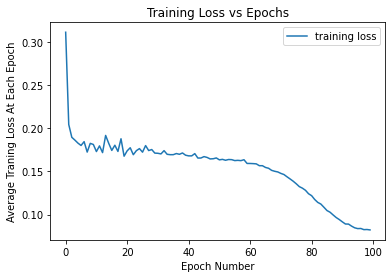

In [ ]:
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

batch_size = 64 #for labeled, unlabeled is this times ratio
#ratio of unlabeled data to use
ratio = 7
#confidence threshold for pseudo label
threshold = 0.95
#weight of unlabeled data loss
weight = 1

lr = 0.01
total_epochs = 100
eval_steps = 1024

criterion = nn.CrossEntropyLoss()
unlabeded_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.001, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_epochs*eval_steps)

l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
u_train_dataloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

save_path = '/content/drive/MyDrive/MLDL/cifar/model/fixmatch_10_50_bestsofar.pth'
save_min_acc = 0.6

train_model(model,
    l_train_dataloader,
    u_train_dataloader,
    test_dataloader,
    lr,
    total_epochs,
    criterion,
    optimizer,
    scheduler,
    save_min_acc,
    save_path,
    eval_steps = eval_steps,
    print_every = 5)

SGAN classifier

In [ ]:
from torch.nn.utils import weight_norm

class Discriminator(nn.Module):
        """docstring for Discriminator"""
        def __init__(self,num_classes):
            super(Discriminator, self).__init__()
            self.net = nn.Sequential(
                    nn.Dropout(.2),
                    weight_norm(nn.Conv2d(3,96,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(96,96,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(96,96,3,stride=2,padding=1)),
                    nn.LeakyReLU(),

                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(96,192,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,3,stride=1,padding=1)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,3,stride=2,padding=1)),
                    nn.LeakyReLU(),
                    
                    nn.Dropout(.5),
                    weight_norm(nn.Conv2d(192,192,3,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,1,stride=1,padding=0)),
                    nn.LeakyReLU(),
                    weight_norm(nn.Conv2d(192,192,1,stride=1,padding=0)),
                    nn.LeakyReLU(),

                    # nn.AvgPool2d(6,stride=1),
                    nn.AdaptiveAvgPool2d(1),
                    nn.Flatten()
                )

            self.fc = weight_norm(nn.Linear(192,num_classes))
            #self.fc = nn.Linear(192,num_classes)
            
        def forward(self,x):
            inter_layer = self.net(x)
            logits = self.fc(inter_layer)
            return logits

epoch: 5  train loss: 0.38267285814799834 val accuracy: 0.3257
ETA of completion: 560.6663228869438 minutes
epoch: 10  train loss: 0.30262929234595504 val accuracy: 0.3775
ETA of completion: 547.1244649887085 minutes
epoch: 15  train loss: 0.26956574339419603 val accuracy: 0.4014
ETA of completion: 509.9804072380066 minutes
epoch: 20  train loss: 0.2519553942111088 val accuracy: 0.4216
ETA of completion: 472.66174666086835 minutes
epoch: 25  train loss: 0.24633134348550811 val accuracy: 0.4208
ETA of completion: 435.1971557736397 minutes
epoch: 30  train loss: 0.24293508689152077 val accuracy: 0.4669
ETA of completion: 409.2108331123988 minutes
epoch: 35  train loss: 0.23782869927526917 val accuracy: 0.5195
ETA of completion: 385.3183511694272 minutes
epoch: 40  train loss: 0.2355510564520955 val accuracy: 0.5374
ETA of completion: 359.0860755443573 minutes
epoch: 45  train loss: 0.23225271581031848 val accuracy: 0.5556
ETA of completion: 325.1191772222519 minutes
epoch: 50  train loss

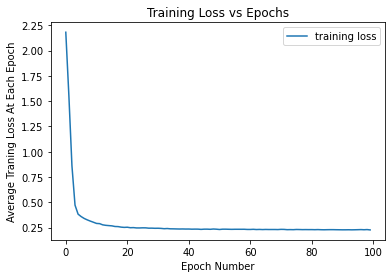

In [ ]:
model = Discriminator(10)

gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

batch_size = 64 #for labeled, unlabeled is this times ratio
#ratio of unlabeled data to use
ratio = 7
#confidence threshold for pseudo label
threshold = 0.95
#weight of unlabeled data loss
weight = 1

lr = 0.0001
total_epochs = 100
eval_steps = 1024

criterion = nn.CrossEntropyLoss()
unlabeded_criterion = nn.CrossEntropyLoss(reduction='none')

#optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.001, nesterov=True)
optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_epochs*eval_steps)

l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
u_train_dataloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

save_path = '/content/drive/MyDrive/MLDL/cifar/model/fixmatch_10_50_sgan_bestsofar.pth'
save_min_acc = 0.5

train_model(model,
    l_train_dataloader,
    u_train_dataloader,
    test_dataloader,
    lr,
    total_epochs,
    criterion,
    optimizer,
    scheduler,
    save_min_acc,
    save_path,
    eval_steps = eval_steps,
    print_every = 5)

## Save checkpoints

In [ ]:
path1 = '/content/drive/MyDrive/MLDL/cifar/model/fixmatch_10_50s_model1.pth'
path2 = '/content/drive/MyDrive/MLDL/cifar/model/fixmatch_10_50s_optimizer1.pth'
path3 = '/content/drive/MyDrive/MLDL/cifar/model/fixmatch_10_50s_scheduler1.pth'

In [ ]:
torch.save(model.state_dict(), path1)
torch.save(optimizer.state_dict(), path2)
torch.save(scheduler.state_dict(), path3)

In [ ]:
state_dict = torch.load(path1) 
model.load_state_dict(state_dict)
state_dict1 = torch.load(path2)
optimizer.load_state_dict(state_dict1)
state_dict2 = torch.load(path3)
scheduler.load_state_dict(state_dict2)

In [ ]:
model = models.resnet50(pretrained=False)
model.fc = nn.Linear(2048, classes)
gpu_boole = torch.cuda.is_available()
if gpu_boole:
  model.cuda()

batch_size = 64 #for labeled, unlabeled is this times ratio
#ratio of unlabeled data to use
ratio = 7
#confidence threshold for pseudo label
threshold = 0.95
#weight of unlabeled data loss
weight = 1

lr = 0.01
total_epochs = 100
eval_steps = 1024

criterion = nn.CrossEntropyLoss()
unlabeded_criterion = nn.CrossEntropyLoss(reduction='none')

optimizer = optim.SGD(model.parameters(), lr = lr, momentum=0.9, weight_decay=0.001, nesterov=True)
#optimizer = optim.Adam(model.parameters(), lr = lr)


l_train_dataloader = DataLoader(train_labeled_dataset, batch_size=batch_size, shuffle=True)
u_train_dataloader = DataLoader(train_unlabeled_dataset, batch_size=batch_size*ratio, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

save_path = '/content/drive/MyDrive/MLDL/cifar100/model/fixmatch_100_bestsofar.pth'
save_min_acc = 0.6


In [ ]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, total_epochs*eval_steps)
for i in range(1024*90):
  scheduler.step()

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


In [ ]:
print(optimizer.state_dict())

{'state': {}, 'param_groups': [{'lr': 0.00024471741852422416, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0.001, 'nesterov': True, 'maximize': False, 'initial_lr': 0.01, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160]}]}


## Clean cache

In [ ]:
del labeled_data, labeled_target, unlabeled_data, l_output, labeled_loss, u_data_s, u_s_output, loss, unlabeded_loss, mask

In [ ]:
gc.collect()
torch.cuda.empty_cache()